In [1]:
import sys; sys.path.insert(0, '..')

In [2]:
from matplotlib import pyplot as plt
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from conf import settings
from utils import get_network, get_test_dataloader
from models.resnet import resnet18

In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [3]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.decomposition import PCA
import numpy as np

## Set up data

In [6]:
baseline_missed = set(np.loadtxt('../baseline_wrong.txt'))
approach3_missed = set(np.loadtxt('../approach3_wrong.txt'))
print('baseline missed: {} | approach 3 missed: {}'.format(len(baseline_missed), len(approach3_missed)))
approach3_desired = baseline_missed - approach3_missed

baseline missed: 2466 | approach 3 missed: 2305


In [7]:
id2label = {}
with open('/nethome/bdevnani3/raid/pytorch-cifar100/id2label.txt', 'r') as handle:
    for idx, line in enumerate(handle):
        if idx % 2 == 0:
            element, label = line.strip().split(': ')
            id2label[int(element)] = label
len(id2label)

100

In [8]:
cifar100_test_loader = get_test_dataloader(
    settings.CIFAR100_TRAIN_MEAN,
    settings.CIFAR100_TRAIN_STD,
    #settings.CIFAR100_PATH,
    num_workers=6,
    batch_size=1,
    shuffle=False
    )

0it [00:00, ?it/s]

Extracting data/cifar-100-python/cifar-100-python.tar.gz to data/cifar-100-python


## Instantiate model

In [9]:
from utils import get_network, get_training_dataloader, get_test_dataloader, WarmUpLR, \
    most_recent_folder, most_recent_weights, last_epoch, best_acc_weights, read_yaml, \
    save_yaml, name_model

# Getting configs

variant_config = read_yaml("/srv/share4/gstoica3/checkpoints/taylor/checkpoints/resnet18/3/CSAM_Approach3_BN_PosEmb0_AfterConv(3, 1, 3)_Temp1_StochStrideFalse_Stride1_ResidualFalse_k-1_0/Tuesday_01_March_2022_17h_05m_40s/convattn.yaml")


In [10]:
from models.csam import ConvAttnWrapper

In [11]:
net = resnet18()

model = ConvAttnWrapper(backbone=net, variant_kwargs=variant_config).to('cuda:0')

../models/csam.py:245: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  self.local_indices[conv_idx] = input_mask[conv_idx].reshape(-1).nonzero().sort()[0].reshape(-1)


In [12]:
path = '/srv/share4/gstoica3/checkpoints/taylor/checkpoints/resnet18/3/CSAM_Approach3_BN_PosEmb0_AfterConv(3, 1, 3)_Temp1_StochStrideFalse_Stride1_ResidualFalse_k-1_0/Tuesday_01_March_2022_17h_05m_40s/resnet18-191-best.pth'


In [13]:
weights = torch.load(path)
net_params = {i[0]:i[1] for i in model.named_parameters()}

In [14]:
model.load_state_dict(weights)

<All keys matched successfully>

In [15]:
model.eval()

ConvAttnWrapper(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2_x): Sequential(
      (0): BasicBlock(
        (residual_function): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (residual_function): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1

In [16]:
desired_images = []
desired_labels = []
wrong_images = []
wrong_labels = []
desired_flag = False
wrong_flag = False
desired_data = 64
for n_iter, (image, label) in tqdm(enumerate(cifar100_test_loader)):
    image = image.cuda()
    if n_iter in approach3_desired and not desired_flag:
        desired_images.append(image)
        desired_labels.append(label)
    if n_iter in approach3_missed and not wrong_flag:
        wrong_images.append(image)
        wrong_labels.append(label)
    if len(desired_images) >= desired_data:
        desired_flag = True
    if len(wrong_images) >= desired_data:
        wrong_flag = True
    if desired_flag and wrong_flag: break


0it [00:00, ?it/s]
109it [00:00, 1089.81it/s]
256it [00:00, 1309.77it/s]
403it [00:00, 1382.41it/s]
682it [00:00, 1396.83it/s]


In [17]:
desired_images = torch.cat(desired_images)
desired_labels = torch.cat(desired_labels)
wrong_images = torch.cat(wrong_images)
wrong_labels = torch.cat(wrong_labels)

In [18]:
predictions = model(wrong_images)

torch.Size([64, 128, 16, 16])
torch.Size([64, 128, 18, 18])


In [19]:
predictions = predictions.argmax(-1).detach().cpu().numpy()

In [20]:
out = wrong_images
inject_layer, inject_number, filter_size = model.variant_kwargs['injection_info'][0]
for layer in tqdm(model.network_structure[:inject_layer]):
    out = layer(out)


100%|██████████| 3/3 [00:00<00:00, 1768.75it/s]


In [21]:
out.shape

torch.Size([64, 128, 16, 16])

In [81]:
import math 
import torch.nn as nn
import sklearn

csam = model.network_structure[inject_layer]
# output = csam.approach3(out)

batch = csam.input_padder(out)
batch = batch.permute(0, 2, 3, 1)
global_mask = (1 - csam.padding_mask - csam.local_mask).flatten(
    start_dim=1, end_dim=-1).reshape(
        csam.convs_height, csam.convs_width, -1)                                                                # [Nc,1,H,W,1]
X = csam.maybe_add_positional_encodings(batch)                                                                  # [B,H,W,E]
batch_size, H, W, _ = X.shape
X_flat_spatial = X.view(-1, H * W, X.shape[-1])                                                                 # [B,HW,E]
X_g_vectors = csam.global_transform(X_flat_spatial)                                                             # [B,HW,C]

# convs_height = self.convs_height
# convs_width = self.convs_width
# For cosine similarity
X_normed = torch.nn.functional.normalize(X, dim=-1)

keys = X_normed
queries = X_normed
denom = 1.

# output = torch.zeros(batch_size, convs_height, convs_width, self.spatial_C, dtype=torch.float).cuda()           # [B,F,F,C]
# TODO: Hack. Assumes Padding is 'same'
# pdb.set_trace()
output = torch.clone(csam.undo_padding(batch.permute(0, 3, 1, 2))).permute(0, 2, 3, 1)
filters = torch.empty((64, 16, 16, 1))
compats = torch.empty((64, 16, 16, 1))

indices = csam.indices
if 'random_k' in csam.approach_args and csam.random_k > 0:
    indices = np.random.permutation(indices)[:csam.random_k]
for i, j in indices:
# for i in range(0, convs_height, self.stride):
#     for j in range(0, convs_width, self.stride):

        X_l = queries[:, i:i+csam.filter_K, j:j+csam.filter_K] / denom                                         # [B,K,K,C]
        raw_compatibilities = torch.einsum('bhwc,bkjc->bhwkj', keys, X_l)                                      # [B,H,W,K,K]
        raw_compatibilities = raw_compatibilities.view(-1, H * W, csam.filter_size)                            # [B,HW,K^2]
        compatabilities = csam.masked_softmax(
            csam.softmax_temp * raw_compatibilities,
            global_mask[i, j].unsqueeze(0).unsqueeze(-1),
            dim=1,
            epsilon=1e-5
            )
        print(compatabilities.shape)
#         for k in range(64):
#             print(compats[k,i,j].shape)
#             print((sklearn.metrics.pairwise.cosine_similarity(compatabilities[k,:,:].detach().cpu().numpy())).shape)
        W_g = torch.bmm(compatabilities.transpose(2, 1), X_g_vectors)                                           # ([B,HW,K^2] -> [B,K^2,HW]) x [B,HW,C] -> [B,K^2,C]
        X_l_flat_spatial = X_l[:,:,:,:csam.spatial_C].reshape(-1, csam.filter_size, csam.spatial_C)             # [B,K^2,C]
        forget_gate = torch.sigmoid(torch.sum(W_g * X_l_flat_spatial, dim=-1, keepdim=True))                    # [B,K^2,1]
        
#         print(compats[:, i, j].shape)
        print(compatabilities.shape)
        
        output[:, i, j] = (forget_gate * X_l_flat_spatial).sum(dim=1)     
        filters[:, i, j] = forget_gate.sum(dim=1)
    
print(output.shape)
print(filters.shape)

torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])
torch.Size([64, 324, 9])


In [39]:
filters.shape

torch.Size([64, 16, 16, 1])

In [41]:
output.shape

torch.Size([64, 16, 16, 128])

In [45]:
out.permute(0,2,3,1)[idx].shape

torch.Size([16, 16, 128])

In [46]:
out.permute(0,2,3,1)[idx].reshape(256, 128).shape

torch.Size([256, 128])

In [57]:
filters[idx].shape

torch.Size([16, 16, 1])

# Visualization Script

In [102]:
idx = 10
batch_pca = PCA(n_components=3)
filter_pca = PCA(n_components=1)
# csam_pca = PCA(n_components=3)

batch_pca.fit(out.permute(0,2,3,1)[idx].reshape(256, 128).detach().cpu().numpy())
filter_pca.fit(filters[idx].reshape(256, 1).detach().cpu().numpy())
batch_pca.fit(output[idx].reshape(256, 128).detach().cpu().numpy())
print('Batch Explained Variance: {}'.format(batch_pca.explained_variance_ratio_))
print('Filter Explained Variance: {}'.format(filter_pca.explained_variance_ratio_))
# print('CSAM Explained Variance: {}'.format(csam_pca.explained_variance_ratio_))

Batch Explained Variance: [0.19712554 0.16873777 0.11338403]
Filter Explained Variance: [1.]


In [103]:
batch_reduced = batch_pca.transform(out.permute(0,2,3,1)[idx].reshape(256, 128).detach().cpu().numpy()).reshape(16, 16, 3)
filter_reduced = filter_pca.transform(filters[idx].reshape(256, 1).detach().cpu().numpy()).reshape(16, 16, 1)
csam_reduced = batch_pca.transform(output[idx].reshape(256, 128).detach().cpu().numpy()).reshape(16, 16, 3)


# Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shark
dolphin


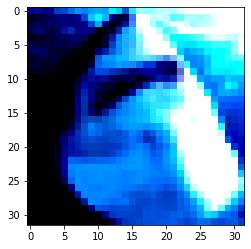

In [104]:
print(id2label[wrong_labels[idx].numpy().tolist()])
print(id2label[predictions[idx]])
image = wrong_images[idx].permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(image)

# Visualization of CSAM Input from Vision Backbone

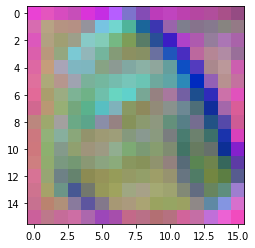

In [105]:
batch_norm = (batch_reduced - np.min(batch_reduced)) / (np.max(batch_reduced) - np.min(batch_reduced))
plt.imshow(batch_norm) 

# Visualization of CSAM Filter 

<AxesSubplot:>

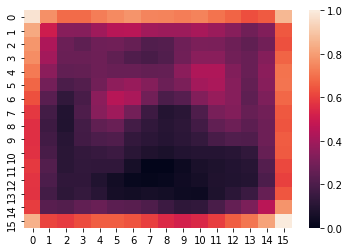

In [106]:
filter_norm = (filter_reduced - np.min(filter_reduced)) / (np.max(filter_reduced) - np.min(filter_reduced))
# plt.imshow(filter_norm)
sns.heatmap(filter_norm.squeeze(-1))

# Visualization of CSAM Output

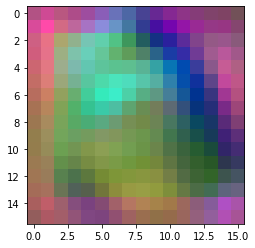

In [107]:
csam_norm = (csam_reduced - np.min(csam_reduced)) / (np.max(csam_reduced) - np.min(csam_reduced))
plt.imshow(csam_norm)

# Visualization of CSAM attention layer 

In [108]:
# TODO

# Combined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


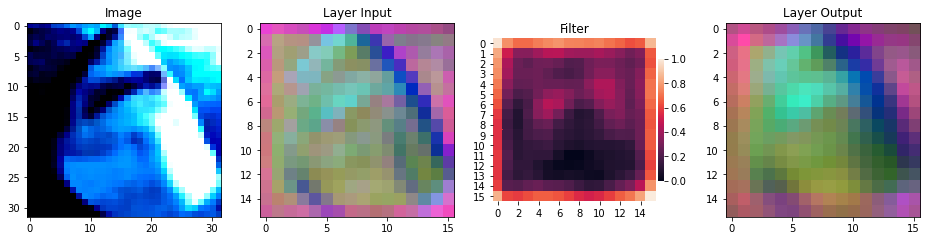

In [109]:
f, axarr = plt.subplots(1,4, figsize=(16,9))
axarr[0].imshow(image)
axarr[0].title.set_text('Image')
axarr[1].imshow(batch_norm)
axarr[1].title.set_text('Layer Input')
axarr[2].imshow(filter_norm)
axarr[2].title.set_text('Filter')
sns.heatmap(filter_norm.squeeze(-1), ax=axarr[2],
           cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
           )
axarr[3].title.set_text('Layer Output')
axarr[3].imshow(csam_norm)
f.show()

In [ ]:
import sklearn
uniform_dist = np.random.uniform(size = filter_norm.shape)
sklearn.metrics.mutual_info_score(filter_norm.flatten(), uniform_dist.flatten())